9/8/2023

Will create an ARIMA model to predict the future sales values of a market using python.

ARIMA: Autoregressive Integrated Moving Average

Install and import the necessary:

In [2]:
!pip install pmdarima

In [3]:
import pandas as pd
# import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot 
from pandas import DataFrame
import os # os module provides functionalits for interact with the operating system

from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from pandas.plotting import autocorrelation_plot

from sklearn.metrics import mean_squared_error
from math import sqrt

from statsmodels.tsa.arima.model import ARIMA

In [13]:
import seaborn as sns

In [4]:
import numpy as np
print(np.__version__)

1.25.2


In [5]:
pip install --upgrade numpy


Note: you may need to restart the kernel to use updated packages.


Now that we have that, let's load in the data and get started!

In [31]:
df = pd.read_csv("C:/Users/valen/Downloads/forecasting/data/sales-cars.csv")

In [32]:
df.head()

,Month,Sales
0,2016-01,266
1,2016-02,146
2,2016-03,183
3,2016-04,119
4,2016-05,180


In [41]:
df.describe()

,Sales
count,36.00000
mean,295.75000
std,117.81908
min,119.00000
25%,192.50000
50%,280.00000
75%,402.75000
max,520.00000


In [43]:
df.shape

(36, 2)

Let's edit the column names by converting the month column of the data to date format.

In [46]:
print(df.columns)

Index(['Month', 'Sales'], dtype='object')


In [47]:
print(df.dtypes)

Month    object
Sales     int64
dtype: object


In [49]:
df.index = pd.to_datetime(df.Month, format = '%Y-%m')

In [50]:
df = df.resample("M").sum()

C:\Users\valen\AppData\Local\Temp/ipykernel_5336/3464654871.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.resample("M").sum()


In [51]:
df.head()

,Sales
Month,
2016-01-31,266
2016-02-29,146
2016-03-31,183
2016-04-30,119
2016-05-31,180


Let's draw a visual to see the distribution of sales

C:\Users\valen\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


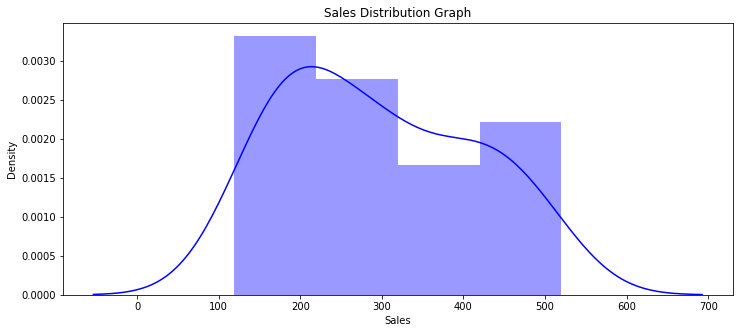

In [52]:
plt.figure(figsize = (12, 5))
plt.title('Sales Distribution Graph')
ax = sns.distplot(df['Sales'], color = 'b')

We have to make sure the data is stationary now. It is important to make sure it is in time series analysis and forecasting. Stationary means a property of time series data where statistical properities: mean, variance, autocorrelation, remain consent over time. 

It is needed because since we are using ARIMA model, this assumes stationarity, violating this assumtion can lead to incorrect results and unreliable forecasting. Also, stationary data tends to lead to show more consistetn patters over time and this lead to making idenifying trends easeir. 

So we will look for the p-value and interpet it.

We will se adfuller library that we imported earlier. This is known as the Augmented Dickey-Fuller test. This is a statistical test used to determine whether a given time series is staitonary or non-stationary. 

In [53]:
def adf_test(dataset):
    
    adtest = adfuller(dataset, autolag = 'AIC')
    
    print('1. ADF: ', adtest[0])
    print('2. P-Value: ', adtest[1])
    print('3. Num of Lags: ', adtest[2])
    print('4. Num of Observations Used for ADF Regression: ', adtest[3])
    print('5. Critical Values: ')
    for key, val in adtest[4].items():
        print("\t", key, ": ", val)
        

adf_test(df['Sales'])
    

1. ADF:  1.6368831572690354
2. P-Value:  0.9979641164504948
3. Num of Lags:  10
4. Num of Observations Used for ADF Regression:  25
5. Critical Values: 
	 1% :  -3.7238633119999998
	 5% :  -2.98648896
	 10% :  -2.6328004


Our P value is  0.9356686982873872

If P < 0.05: the data is stationary, if P > 0.05 the data is not staitonary

So we concldue that the data is not stationary based on the ADF test. When we get into createing the ARIMA model, we need to specify the "d" value in order to amke this data stationary. Let's get into that now.

When we are creating the ARIMA model, there are 3 parameters given: p, d, and q.

p - also known as autoregressive order: represents the order of the autoregressive componenet that captures the relationship between the current valye of the time series and the pass values. So, if p is set to 1, it means that the current value depends on the immediete preceding value, this is simple. If p is greater than 1 that it implies that the current value depends on the previous "p" values, therefore, a higher p value captures more complex patters in data.

d - also known as differencing order: represnts the order of differencing applied to the time series to make it stationary. the differencing invovle subtracting the time series observations from their previous values and this helps remove trends which makes it more stationary. so, if d is set to 1, it means first-order differencing, where each observation is substrcted from its preceding obervation. if "d" is greater than one that this implies higher-order differenicging, which may be necessary for strongly non-stationary data. (in this case we will be in this area). in the end, the goal of differencing is to eliminate seasonallity and trends in the data so that it become stationary.

q - also known as moving average order: represents the order of the moving average component of the modle. this component models the relationship between the current value of the time series and past white noise, random error terms. So, if q is set to 1 it is a first-order moving average model, where the current value depends on the pervious random error term. If q is greater than 1, then similarly, this implies that the current value dpends on the pervious q randoom error terms. And, similarly, a higher q value captures more complex structures.

Now that we have an understanding let's continue!

In order to decide how good the predictionn model is to use the auto_arima function, where it treis to minimize the AIC score.

The AIC score, Akaike Information Criterion score measures the goodness of fit of a model to a dataset and it also takes into account the model's complexity.

AIC =−2⋅ln(L)+2k

- L : the likelihood of the model, this measures how well the model fits the data
- k : the number of parameters in the model

In [54]:
stepwise = auto_arima(df['Sales'], trace = True, supress_warnings = True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=416.144, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=393.468, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=392.946, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=414.316, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=389.041, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=391.011, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=390.561, Time=0.36 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=388.655, Time=0.30 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.588 seconds


The function gave the ARIMA parameters (2,1,2) the best score.

Based on the text from before, this means that we have difined a 2nd order autoregressive model and a second moving average model.

Now that we have the paramters, let's move onto the data and start separating.

In [70]:
X = df.values #assigning the values of df to X
size = int(len(X) * 0.65) #taking 66% of the ds and converting it to an int()
train, test = X[0: size], X[size:len(X)] #split into train and test
history = [x for x in train] #initilizes history list and populate it with the values of training ds (used to keep track of the historical data points as we iterate through the dataset)
predictions = list() #initializes an empty predictions list which will be used to store the predictions made

Now we move to fitting the ARIMA Model.

In [71]:
for t in range(len(test)):
    model = ARIMA(history, order = (0,1,2))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('Predicted = %f, Expected = %f' % (yhat, obs))

C:\Users\valen\AppData\Local\Temp/ipykernel_5336/3945619616.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Predicted = %f, Expected = %f' % (yhat, obs))


Predicted = 342.688061, Expected = 342.000000
Predicted = 332.718095, Expected = 340.000000
Predicted = 333.596915, Expected = 440.000000
Predicted = 315.729583, Expected = 316.000000
Predicted = 381.990070, Expected = 439.000000
Predicted = 368.033062, Expected = 401.000000
Predicted = 397.209020, Expected = 390.000000
Predicted = 444.595219, Expected = 490.000000
Predicted = 414.849189, Expected = 408.000000
Predicted = 459.661810, Expected = 490.000000
Predicted = 443.550592, Expected = 420.000000
Predicted = 479.502346, Expected = 520.000000
Predicted = 443.878524, Expected = 480.000000


Now that we we have the model let's move on to evaluating it.

In [72]:
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: % .3f' % rmse)

Test RMSE:  41.410


Now that we have the rmse error amont we can see the forecast and actual values on the graph.

The the actual values are depicted in blue and the estimated values are depeicted in red.

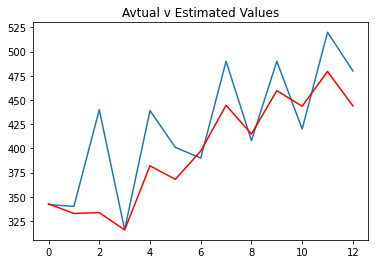

In [73]:
pyplot.plot(test)
pyplot.plot(predictions, color = 'red')
pyplot.title('Avtual v Estimated Values')
pyplot.show()

From the red line, which describes the output of the model for future periods and the blue line which has aactually occured in the above output image. 

As we can see, the prediction model does not fully overlap with the real values in order to make a consistent prediction without beeing too risky. But, the predicted values and actual values both exhibit a consistent pattern of trending upwards and downwards over time. This consistency is valuable because it indicates that our model isn't excessively fitting to noise in the data, and so we will take it, for now. 

However, it's essential to continue monitoring the model's performance and potentially make improvements as needed to ensure it remains accurate and reliable in the long term.